# 数据处理

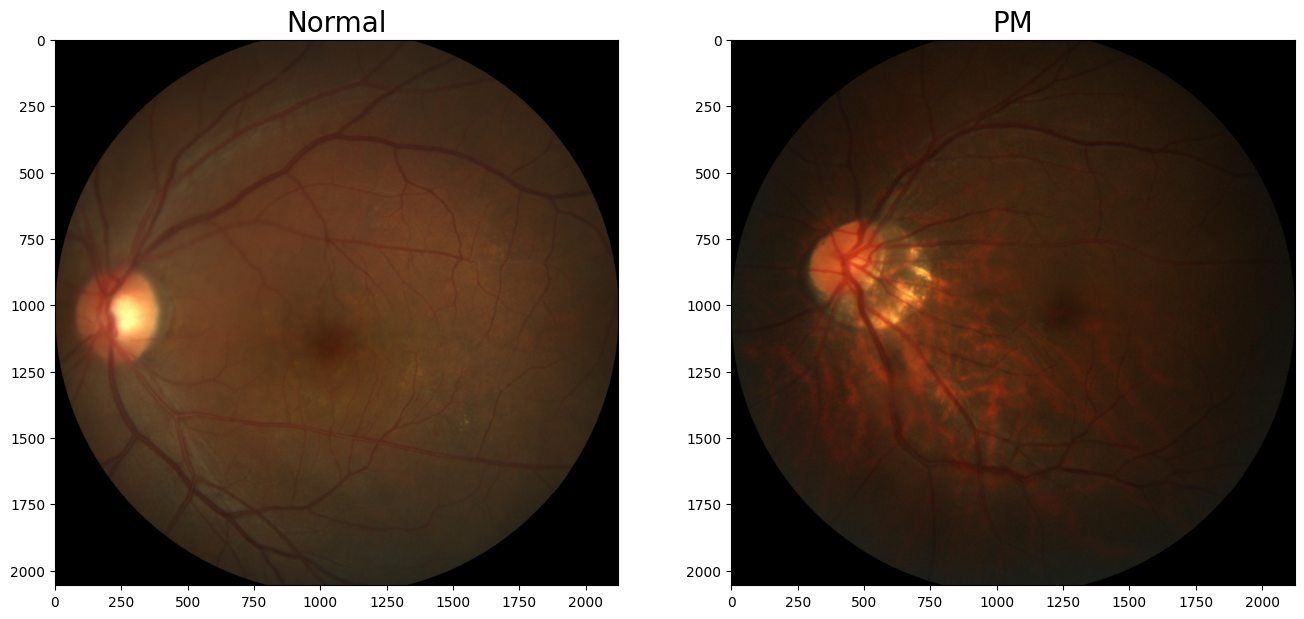

In [2]:

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

DATADIR = 'E:\Myproject\DataSet\EYE\work\plam/PALM-Training400/PALM-Training400/'
# 以N开头是正常，以P开头是病变
file1 = 'N0012.jpg'
file2 = 'P0094.jpg'

# 读取图片
img1 = Image.open(os.path.join(DATADIR, file1))
img1 = np.array(img1)
img2 = Image.open(os.path.join(DATADIR, file2))
img2 = np.array(img2)
# 这是一条这测试

# 画出读取的图片
plt.figure(figsize=(16, 8))
f = plt.subplot(121)
f.set_title('Normal', fontsize=20)
plt.imshow(img1)
f = plt.subplot(122)
f.set_title('PM', fontsize=20)
plt.imshow(img2)
plt.show()

In [3]:
img1.shape,
img2.shape

(2056, 2124, 3)

In [4]:
# 调整图片大小
# 归一化
import cv2
import numpy as np

def transform_img(img):
    # 调整成为224*224
    img = cv2.resize(img, (224,224))
    # 读取的格式为hwc
    # 转变为chw
    img = np.transpose(img, (2,0,1))
    img = img.astype('float32')
    img = img /255
    img = img * 2.0 -1.0
    return img


In [5]:
# 定义dataloader（）

import cv2
import random
import numpy as np
import os

# 定义训练集读取数据
def data_loader(datadir, batch_size=10, mode = 'train'):
    # 将datadir下的文件读取出来，每条都要读
    filenames = os.listdir(datadir)
    def reader():
        if mode == 'train':
            # 训练时打乱数据
            random.shuffle(filenames)
        batch_imgs = []
        batch_labels = []
        for name in filenames:
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            if name[0] == 'H' or name[0] == 'N':
                label = 0
            elif name[0]== 'P':
                label = 1
            else:
                raise('Not except file name')
            # 每读取一个，就加入一个
            batch_imgs.append(img)
            batch_labels.append(label)

            if len(batch_imgs) == batch_size:
                 imgs_arry = np.array(batch_imgs).astype('float32')
                 labels_arry = np.array(batch_labels).reshape(-1,1)
                 yield imgs_arry, labels_arry
                 batch_imgs = []
                 batch_labels = []
        
        if len(batch_imgs) >0:
            # 剩下的不足一个批次
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).reshape(-1, 1)
            yield imgs_array, labels_array
            
    return reader

# 定义验证集读取器
def valid_data_loader(datadir, csvfile, batch_size=10, mode = 'valid'):
    filelists = open(csvfile).readlines()
    def reader():
        batch_imgs = []
        batch_labels = []
        for line in filelists[1:]:
            line = line.strip().split(',')
            name = line[1]
            label = int(line[2])
            # 加载图片，预处理
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            # 读取一个就放一个
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).reshape(-1, 1)
            yield imgs_array, labels_array

    return reader



In [6]:
import paddle
paddle.seed(100)
# 查看数据形状

DATADIR = 'E:\Myproject\DataSet\EYE\work\plam/PALM-Training400/PALM-Training400/'
train_loader = data_loader(DATADIR,
                           batch_size=10, mode='train')
data_reader = train_loader()
data = next(data_reader)
data[0].shape, data[1].shape

eval_loader = data_loader(DATADIR,
                          batch_size=10, mode='eval')
data_reader = eval_loader()
data = next(data_reader)
data[0].shape, data[1].shape

((10, 3, 224, 224), (10, 1))

In [7]:

from paddle.vision.models import resnet50
model = resnet50()

In [8]:
import paddle.nn.functional as F
loss_fn = F.cross_entropy

In [18]:
# -*- coding: utf-8 -*-
# LeNet 识别眼疾图片

import os
import random
import paddle
import numpy as np

class Runner(object):
    def __init__(self, model, optimizer, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn

        # 记录全局最优
        self.best_acc = 0

    def train_pm(self, train_datadir, val_datadir, **kwargs):
        print('start training')
        self.model.train()

        num_epochs = kwargs.get('num_epochs', 0)
        csv_file = kwargs.get('csv_file', 0)
        save_path = kwargs.get('save_path', 'E:\Myproject\DataSet\EYE')

        # 定义数据读取器
        train_loader = data_loader(train_datadir, batch_size=10, mode='train')

        # 每一个epoch开始循环
        for epoch in range(num_epochs):
            for batch_id, data in enumerate(train_loader()):
                imgs, labels = data 
                img = paddle.to_tensor(imgs)
                label = paddle.to_tensor(labels)
                # 前向预测
                logits = model(img)
                avg_loss = self.loss_fn(logits, label)

                if batch_id % 20 == 0:
                    print("epoch: {}, batch_id: {}, loss is: {:.4f}".format(epoch, batch_id, float(avg_loss.numpy())))
                
                # 反向传播
                avg_loss.backward()
                self.optimizer.step()
                self.optimizer.clear_grad()
            
            acc = self.evaluate_pm(val_datadir, csv_file)
            self.model.train()
            if acc > self.best_acc:
                self.save_model(save_path)
                self.best_acc = acc
    # 模型评估paddle.no_grad()
    @paddle.no_grad()
    def evaluate_pm(self, val_datadir, csv_file):
        self.model.eval()
        accuracies = []
        losses = []
        # 验证集读取数据
        valid_loader = valid_data_loader(val_datadir, csv_file)

        for batch_id, data in enumerate(valid_loader()):
            imgs, labels = data 
            img = paddle.to_tensor(imgs)
            label = paddle.to_tensor(labels)
            # 前向计算
            logits = self.model(img)
            # softmax
            pred = F.softmax(logits)
            loss = self.loss_fn(pred, label)
            acc = paddle.metric.accuracy(pred, label)
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())
        print("[validation] accuracy/loss: {:.4f}/{:.4f}".format(np.mean(accuracies), np.mean(losses)))
        return np.mean(accuracies)
    
    @paddle.no_grad()
    def predict_pm(self, x, **kwargs):
        self.model.eval()  # 开启评估，也就是不批归一化，也不随即丢弃
        logits = self.model(x)
        return logits
    
    def save_model(self, save_path):
        paddle.save(self.model.state_dict(), save_path + 'palm.pdparams')
        paddle.save(self.optimizer.state_dict(), save_path + 'palm.pdopt')
    
    def load_model(self, model_path):
        model_state_dict = paddle.load(model_path)
        self.model.set_state_dict(model_state_dict)

<>:24: DeprecationWarning: invalid escape sequence \M
<>:24: DeprecationWarning: invalid escape sequence \M
C:\Users\24612\AppData\Local\Temp\ipykernel_4040\4202537327.py:24: DeprecationWarning: invalid escape sequence \M
  save_path = kwargs.get('save_path', 'E:\Myproject\DataSet\EYE')


In [19]:
use_gpu = True
paddle.device.set_device('gpu:0') if use_gpu else paddle.device.set_device('cpu')

# 定义优化其
opt = paddle.optimizer.SGD(learning_rate = 0.001, parameters=model.parameters())

run = Runner(model, opt, loss_fn)

In [20]:
import os
# s数据路径
DATADIR = 'E:\Myproject\DataSet\EYE\work\plam\PALM-Training400\PALM-Training400'
DATADIR2 = 'E:\Myproject\DataSet\EYE\work\plam\PALM-Validation400'
CSVFILE =  'E:\Myproject\DataSet\EYE\work\plam\labels.csv'
# 迭代参数
EPOCH_NUM = 5
SAVE_PATH = 'E:\Myproject\DataSet\EYE'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
run.train_pm(DATADIR, DATADIR2
             ,num_epochs=EPOCH_NUM, csv_file = CSVFILE, save_path=SAVE_PATH)

<>:3: DeprecationWarning: invalid escape sequence \M
<>:4: DeprecationWarning: invalid escape sequence \M
<>:5: DeprecationWarning: invalid escape sequence \M
<>:8: DeprecationWarning: invalid escape sequence \M
<>:3: DeprecationWarning: invalid escape sequence \M
<>:4: DeprecationWarning: invalid escape sequence \M
<>:5: DeprecationWarning: invalid escape sequence \M
<>:8: DeprecationWarning: invalid escape sequence \M
C:\Users\24612\AppData\Local\Temp\ipykernel_4040\1013839604.py:3: DeprecationWarning: invalid escape sequence \M
  DATADIR = 'E:\Myproject\DataSet\EYE\work\plam\PALM-Training400\PALM-Training400'
C:\Users\24612\AppData\Local\Temp\ipykernel_4040\1013839604.py:4: DeprecationWarning: invalid escape sequence \M
  DATADIR2 = 'E:\Myproject\DataSet\EYE\work\plam\PALM-Validation400'
C:\Users\24612\AppData\Local\Temp\ipykernel_4040\1013839604.py:5: DeprecationWarning: invalid escape sequence \M
  CSVFILE =  'E:\Myproject\DataSet\EYE\work\plam\labels.csv'
C:\Users\24612\AppData\L

start training


e:\SoftWare\Program\Anaconda\envs\d2l\lib\site-packages\paddle\nn\layer\norm.py:712: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


epoch: 0, batch_id: 0, loss is: 0.5067
epoch: 0, batch_id: 20, loss is: 0.5009
[validation] accuracy/loss: 0.8950/6.2544


e:\SoftWare\Program\Anaconda\envs\d2l\lib\site-packages\paddle\framework\io.py:828: UserWarning: The input state dict is empty, no need to save.
  warnings.warn("The input state dict is empty, no need to save.")


epoch: 1, batch_id: 0, loss is: 0.5514
epoch: 1, batch_id: 20, loss is: 0.5156
[validation] accuracy/loss: 0.8525/6.2305
epoch: 2, batch_id: 0, loss is: 0.5561
epoch: 2, batch_id: 20, loss is: 0.3160
[validation] accuracy/loss: 0.8875/6.2128
epoch: 3, batch_id: 0, loss is: 0.3566
epoch: 3, batch_id: 20, loss is: 0.4299
[validation] accuracy/loss: 0.9100/6.1625
epoch: 4, batch_id: 0, loss is: 0.3044
epoch: 4, batch_id: 20, loss is: 0.2396
[validation] accuracy/loss: 0.9050/6.1393


In [21]:
# 模型评估
run.load_model('E:\Myproject\DataSet\EYEpalm.pdparams')
# 评价
score = run.evaluate_pm(DATADIR2, CSVFILE)

<>:2: DeprecationWarning: invalid escape sequence \M
<>:2: DeprecationWarning: invalid escape sequence \M
C:\Users\24612\AppData\Local\Temp\ipykernel_4040\1484097968.py:2: DeprecationWarning: invalid escape sequence \M
  run.load_model('E:\Myproject\DataSet\EYEpalm.pdparams')


[validation] accuracy/loss: 0.9100/6.1625


In [ ]:
# 模型预测

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import paddle
import paddle.nn.functional as F
%matplotlib inline

